In [2]:
from Bio import PDB
from Bio.PDB import *
import numpy as np
from scipy.spatial.transform import Rotation
from Bio.PDB import Residue, Atom
from IPython.display import clear_output
import py3Dmol
import json
import os

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem

 

file = r'C:\Users\bashc\Desktop\working\Nanotube_CC2.pdb'
# Read the PDB file
mol = Chem.MolFromPDBFile(file, removeHs=False)

# Check if the molecule was successfully loaded
if mol is not None:
    # Add hydrogens and generate 3D coordinates
    #mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    
    # Write the molecule to an SDF file
    writer = Chem.SDWriter(sdf_file)
    writer.write(mol)
    writer.close()
    print(f"Converted {file} to {sdf_file}")
else:
    print(f"Failed to load molecule from {file}")
 

Failed to load molecule from C:\Users\bashc\Desktop\working\Nanotube_CC2.pdb


[12:48:55] Explicit valence for atom # 278 C, 5, is greater than permitted


In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem
import os

file = r'C:\Users\bashc\Desktop\working\tripleHeme.pdb'
# Define path for SDF output
sdf_file = r'C:\Users\bashc\Desktop\working\tripleHeme.sdf'


# Open and analyze the PDB file
print(f"Analyzing {file} for valence issues...")
mol_no_sanitize = Chem.MolFromPDBFile(file, removeHs=False, sanitize=False)

#save the molecule to an SDF file
writer = Chem.SDWriter(sdf_file)
writer.write(mol_no_sanitize)
writer.close()
print(f"Converted {file} to {sdf_file}")

#convert to smiles
smiles = Chem.MolToSmiles(mol_no_sanitize)
print(f"SMILES: {smiles}")

Analyzing C:\Users\bashc\Desktop\working\tripleHeme.pdb for valence issues...
Converted C:\Users\bashc\Desktop\working\tripleHeme.pdb to C:\Users\bashc\Desktop\working\tripleHeme.sdf
SMILES: CCC1C(C)C2CC3C(C)C(CCC(O)O)C4CC5C(CCC(O)O)C(C)[C@@H]6[C@@H]([C@@H]7[C@H]8C(C)C(CCC(O)O)C9CC%10C(CCC(O)O)C(C)[C@@H]%11[C@H]([C@H]%12[C@H]%13C(C)C(CCC(O)O)C%14CC%15C(CCC(O)O)C(C)C%16CC%17C(C)C(CC)C%18CC%19C(C)C(CC)[C@@H]%12N%19[Fe@SP2](N%16%15)(N%17%18)N%14%13)[C@@H]%12C(CC)C(C)C%13CC%14C(CC)C(C)[C@@H]7N%14[Fe@SP1](N98)(N%10%11)N%13%12)[C@@H]7C(CC)C(C)C8CC1N2[Fe@SP1](N34)(N56)N87


In [ ]:
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np

# Load the CIF file instead of PDB
print(f"Loading CIF file: {file}")
# Change PDBFile to PDBxFile for CIF files
structure = PDBxFile(file)

# First, try to identify which atoms belong to the nanotube
# We'll assume carbon atoms that aren't part of standard residues are part of the nanotube
nanotube_atoms = set()
for atom in structure.topology.atoms():
    # If residue is not a standard protein/DNA residue, it's likely part of the nanotube
    if atom.residue.name not in ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 
                                 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 
                                 'THR', 'TRP', 'TYR', 'VAL', 'HIP', 'HIE', 'HID', 'DA', 
                                 'DC', 'DG', 'DT', 'A', 'C', 'G', 'T', 'U']:
        nanotube_atoms.add(atom.index)

# Identify interface bonds between nanotube and biomolecules
interface_bonds = []
for bond in structure.topology.bonds():
    # If one atom is in nanotube and the other is not, it's an interface bond
    if (bond.atom1.index in nanotube_atoms and bond.atom2.index not in nanotube_atoms) or \
       (bond.atom2.index in nanotube_atoms and bond.atom1.index not in nanotube_atoms):
        interface_bonds.append((bond.atom1.index, bond.atom2.index))

print(f"Found {len(interface_bonds)} interface bonds between nanotube and biomolecules")

# Create a force field for standard biomolecules
forcefield = ForceField('amber14-all.xml', 'amber14/tip3p.xml')

# Create a system with the standard force field first
try:
    # This will work for the standard biomolecules
    system = forcefield.createSystem(
        structure.topology,
        nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer,
        constraints=HBonds
    )
    print("Created system with standard force field")
except Exception as e:
    # If it fails, create an empty system and we'll populate it manually
    print(f"Standard force field failed: {e}")
    system = System()
    # Add particles with appropriate masses
    for atom in structure.topology.atoms():
        if atom.element:
            system.addParticle(atom.element.mass)
        else:
            system.addParticle(12.0 * amu)  # Default to carbon mass

# Add custom parameters only for nanotube atoms
if nanotube_atoms:
    print(f"Adding custom parameters for {len(nanotube_atoms)} nanotube atoms")
    
    # Add bonds for nanotube atoms
    bond_force = None
    for force in system.getForces():
        if isinstance(force, HarmonicBondForce):
            bond_force = force
            break
    
    if bond_force is None:
        bond_force = HarmonicBondForce()
        system.addForce(bond_force)
    
    # Add nanotube bonds
    for bond in structure.topology.bonds():
        if bond.atom1.index in nanotube_atoms and bond.atom2.index in nanotube_atoms:
            # Carbon-carbon bond parameters (typical for sp2 carbons)
            k = 478.0 * kilocalories_per_mole/angstroms**2
            length = 1.42 * angstroms  # for carbon nanotubes
            bond_force.addBond(bond.atom1.index, bond.atom2.index, length, k)
    
    # Add interface bonds to ensure nanotube connects to biomolecules
    for atom1_idx, atom2_idx in interface_bonds:
        # Use a generic carbon-carbon/carbon-nitrogen bond parameter
        k = 400.0 * kilocalories_per_mole/angstroms**2
        length = 1.5 * angstroms  # slightly longer for interface bonds
        # Check if this bond already exists in the force
        exists = False
        for i in range(bond_force.getNumBonds()):
            particle1, particle2, _, _ = bond_force.getBondParameters(i)
            if (particle1 == atom1_idx and particle2 == atom2_idx) or \
               (particle1 == atom2_idx and particle2 == atom1_idx):
                exists = True
                break
        if not exists:
            bond_force.addBond(atom1_idx, atom2_idx, length, k)
            print(f"Added interface bond between atoms {atom1_idx} and {atom2_idx}")
    
    # Add angle force for nanotube atoms
    angle_force = None
    for force in system.getForces():
        if isinstance(force, HarmonicAngleForce):
            angle_force = force
            break
    
    if angle_force is None:
        angle_force = HarmonicAngleForce()
        system.addForce(angle_force)
    
    # Identify angles in nanotube
    for atom2 in structure.topology.atoms():
        if atom2.index not in nanotube_atoms:
            continue
            
        connected_atoms = []
        for bond in structure.topology.bonds():
            if bond.atom1.index == atom2.index:
                connected_atoms.append(bond.atom2)
            elif bond.atom2.index == atom2.index:
                connected_atoms.append(bond.atom1)
        
        # Create angles from all pairs of connected atoms
        for i in range(len(connected_atoms)):
            for j in range(i+1, len(connected_atoms)):
                atom1 = connected_atoms[i]
                atom3 = connected_atoms[j]
                # Parameters for sp2 carbon
                theta0 = 2.09439510 * radians  # 120 degrees
                k = 63.0 * kilocalories_per_mole/radians**2
                angle_force.addAngle(atom1.index, atom2.index, atom3.index, theta0, k)

# Add a restraint force to keep atoms near their starting positions
restraint_force = CustomExternalForce("k*((x-x0)^2+(y-y0)^2+(z-z0)^2)")
restraint_force.addGlobalParameter("k", 5.0*kilocalories_per_mole/angstrom**2)
restraint_force.addPerParticleParameter("x0")
restraint_force.addPerParticleParameter("y0")
restraint_force.addPerParticleParameter("z0")

positions = structure.positions
for i, pos in enumerate(positions):
    restraint_force.addParticle(i, [pos.x, pos.y, pos.z])
system.addForce(restraint_force)

# Create an integrator
integrator = LangevinMiddleIntegrator(
    300*kelvin,       # Temperature 
    1/picosecond,     # Friction coefficient
    0.002*picoseconds # Time step
)

# Create a simulation object
simulation = Simulation(structure.topology, system, integrator)
simulation.context.setPositions(structure.positions)

# Print initial energy
state = simulation.context.getState(getEnergy=True)
print(f"Initial potential energy: {state.getPotentialEnergy()}")

# Minimize energy
print("Minimizing energy...")
simulation.minimizeEnergy(maxIterations=1000)

# Print final energy
state = simulation.context.getState(getEnergy=True, getPositions=True)
print(f"Final potential energy: {state.getPotentialEnergy()}")

# Get the minimized positions
minimized_positions = state.getPositions()

# Create a CIF file with the relaxed structure
relaxed_cif_path = file.replace('.cif', '_relaxed.cif')
with open(relaxed_cif_path, 'w') as f:
    PDBxFile.writeFile(
        structure.topology,
        minimized_positions,
        f
    )

print(f"Relaxed structure saved to {relaxed_cif_path}")


In [ ]:
#copy file to a new directory (keeping the original file)
import shutil
import os
attemptFile = f'./inputs/{os.path.basename(file)}_{cc}.pdb'

In [6]:
def load_fasta(file_path):
    sequences = []
    with open(file_path, 'r') as file:
        while True:
            comment = file.readline().strip()
            if not comment:
                break
            sequence = file.readline().strip()
            if 'overall_confidence' in comment:# and 'working2_Combin4' in comment:
                #comment format -> ">working_04, id=1, T=0.044000000000000004, seed=37763, overall_confidence=0.2417, ligand_confidence=0.2186, seq_rec=0.2693"
                comment = 'file=' + comment[1:]
                json_data = {key: (value).strip() for key, value in [item.split('=') for item in comment.split(', ')]}
                json_data['overall_confidence']= float(json_data['overall_confidence'])
                json_data['ligand_confidence']= float(json_data['ligand_confidence'])
                json_data['seq_rec']= float(json_data['seq_rec'])
                sequences.append((json_data , sequence))
    return sequences
pdb_sourceFolder = r'D:\PythonProj\structures' 
file_path = r'D:\Downloads\batch (12).fa'
sequences = load_fasta(file_path)
# Sort sequences by 'overall_confidence' in json_data and select the top value
sorted_sequences = sorted(sequences, key=lambda x: x[0]['ligand_confidence'], reverse=True)
# Print out the top 5 sequences with their overall confidence
for i, (json_data, sequence) in enumerate(sorted_sequences[:15]):
    print(f"Sequence {i+1}:")
    print(f"Overall Confidence: {json_data['overall_confidence']} {json_data['ligand_confidence']} {json_data['seq_rec']}")
    print(f"Source File: {json_data['file']}")
    parts= sequence.split(':')
    for part in parts:
        print(part)

Sequence 1:
Overall Confidence: 0.3833 0.4499 0.4103
Source File: p2erturbed_13
AEAARAAAIAEFAALGAELERELEGLEEERREARRRIGEILRRLGPEVTVEAEAYPTLVEIHRIAYAATREVGWTPERLRLVVEHLRLLFEANRGRTLTREELEFMREVMTIAAARAATVREEHLETVRELHRIVFSPTARAMPRTPEFREMVIIHHRIAAARAATVTEEHLATVVEIHRLFFETSPYTRRPIPEIFLIMCIIHTIIAAARRARRTTPERLAAVVAIHRIGFTRLPEIPEERRETVYWFWIVHAIGAAAVGETLPEDRPERYARLVALHIVLFALWLATPLTEAQRLALAVVGAVVGAAALR
Sequence 2:
Overall Confidence: 0.3661 0.4452 0.4647
Source File: working2_Combin4
EEEARRRAVEEIRALERELRERLEGLEEERREAIRRLHEIHERLGPRVRTPAEAYPTLIEHHRITVAALEEVGWTPEILELIVRTTELVLRAREGRTITREEVEFALEHTTIVLAHLPTFREEVLRTALEMHRIAFSPRARARPRTPEYREWLLEHTRLVLAHAPTFTEEVLRTIVEMHRIAIELSPYYEEPIPLERLRRHLAHTAAVLAFLERFTTEELLRTWVITHWIGITTERFVPEERRRTREVYAIVHTVTVLATLERLPRDRPWIYTLIVIHHFVLTAIGLATPLTEAERIARVVVGGVVGARLLR
Sequence 3:
Overall Confidence: 0.377 0.4447 0.3878
Source File: p2erturbed_13
EAAARARTIAARAALGAALMAELEGLEEERRAARARIGEILRTLGPQVTVEAEAYPTLEEIHRIAYAATREIGWTPERLRLVVEHLEILFRARRGRTITREELEFMRRVMTIAAARAATVRPEHRRTIIELH

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser, PDBIO, NeighborSearch, Selection, vectors
from Bio.PDB.PDBExceptions import PDBConstructionWarning
import warnings
import math
from collections import defaultdict
import py3Dmol
from IPython.display import display
def calculate_phi_psi(residue_list):
    """
    Calculate phi/psi angles for residues in a chain
    
    Args:
        residue_list: List of residues from a Biopython chain
        
    Returns:
        List of dictionaries containing residue info and phi/psi angles
    """
    phi_psi_list = []
    
    for i in range(len(residue_list)):
        res = residue_list[i]
        
        # Skip non-amino acid residues
        if res.get_id()[0] != " ":
            continue
            
        # Get previous and next residues
        prev_res = None if i == 0 else residue_list[i-1]
        next_res = None if i == len(residue_list)-1 else residue_list[i+1]
        
        # Calculate phi (requires previous residue)
        phi = None
        if prev_res and prev_res.get_id()[0] == " ":
            if 'C' in prev_res and 'N' in res and 'CA' in res and 'C' in res:
                phi = calc_dihedral(prev_res['C'].get_vector(),
                                  res['N'].get_vector(),
                                  res['CA'].get_vector(),
                                  res['C'].get_vector())
        
        # Calculate psi (requires next residue)
        psi = None
        if next_res and next_res.get_id()[0] == " ":
            if 'N' in res and 'CA' in res and 'C' in res and 'N' in next_res:
                psi = calc_dihedral(res['N'].get_vector(),
                                  res['CA'].get_vector(),
                                  res['C'].get_vector(),
                                  next_res['N'].get_vector())
                
        # Convert to degrees if angles were calculated
        if phi is not None:
            phi = math.degrees(phi)
        if psi is not None:
            psi = math.degrees(psi)
            
        if phi is not None and psi is not None:
            phi_psi_list.append({
                'residue': f"{res.get_resname()}_{res.id[1]}",
                'phi': phi,
                'psi': psi
            })
    
    return phi_psi_list

def calc_dihedral(v1, v2, v3, v4):
    """Calculate dihedral angle between 4 vectors"""
    return vectors.calc_dihedral(v1, v2, v3, v4)

def generate_ramachandran_plot(phi_psi_data, chain_id, output_path=None):
    """Generate a Ramachandran plot from phi/psi angles"""
    if not phi_psi_data:
        print(f"No phi/psi data for chain {chain_id}, skipping Ramachandran plot")
        return False
        
    phi_values = [entry['phi'] for entry in phi_psi_data]
    psi_values = [entry['psi'] for entry in phi_psi_data]
    
    plt.figure(figsize=(10, 8))
    plt.scatter(phi_values, psi_values, alpha=0.7)
    
    # Mark common secondary structure regions
    # Alpha helix region
    alpha_x = [-65, -65, -55, -55, -65]
    alpha_y = [-45, -35, -35, -45, -45]
    plt.plot(alpha_x, alpha_y, 'r-', label='Alpha Helix')
    
    # Beta sheet region
    beta_x = [-140, -140, -110, -110, -140]
    beta_y = [130, 150, 150, 130, 130]
    plt.plot(beta_x, beta_y, 'b-', label='Beta Sheet')
    
    # Set plot limits
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)
    
    # Add gridlines
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add labels and title
    plt.xlabel('Phi (degrees)')
    plt.ylabel('Psi (degrees)')
    plt.title(f'Ramachandran Plot - Chain {chain_id}')
    
    # Add axis lines at 0
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    # Add legend
    plt.legend()
    
    # Save plot if output path is provided
    plt.show()
    
    return True
    
    

def has_amino_acids(chain):
    """Check if a chain contains amino acid residues"""
    standard_aa = set([
        'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE',
        'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'
    ])
    
    # Check if chain has at least one standard amino acid
    for residue in chain:
        if residue.get_resname() in standard_aa:
            return True
    
    return False    

Parsing structure from D:\Downloads\fold_shorthack5\New folder\test1.pdb...
Analyzing steric clashes...
Clash report saved to D:\Downloads\fold_shorthack5\New folder\test1_clash_report.txt
Calculating phi/psi angles for chain A...


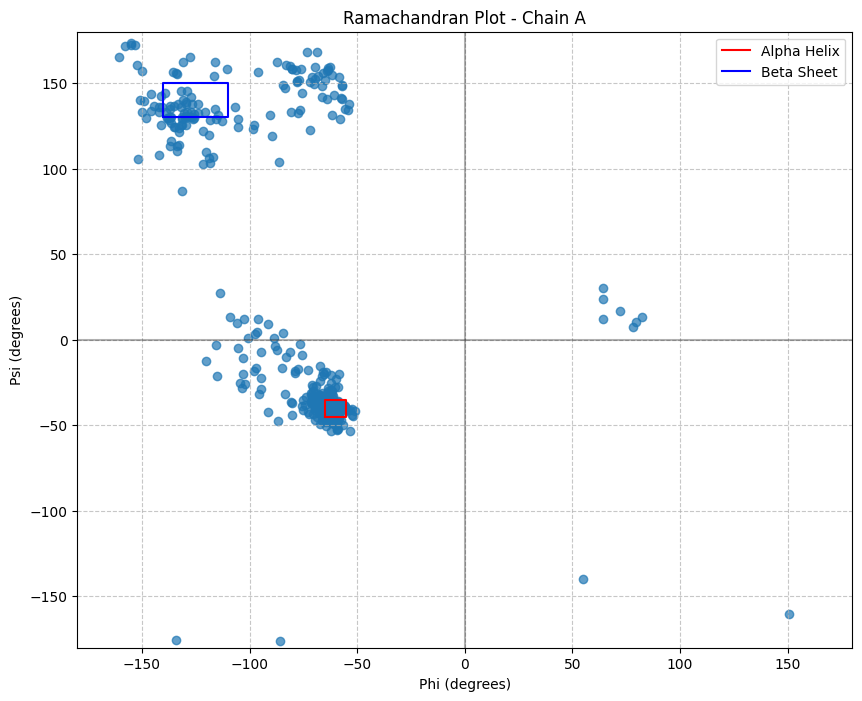

Chain B has no amino acids, skipping Ramachandran analysis
Chain C has no amino acids, skipping Ramachandran analysis
Chain D has no amino acids, skipping Ramachandran analysis
Chain E has no amino acids, skipping Ramachandran analysis
Chain F has no amino acids, skipping Ramachandran analysis
Chain G has no amino acids, skipping Ramachandran analysis
Chain H has no amino acids, skipping Ramachandran analysis
Chain I has no amino acids, skipping Ramachandran analysis
Chain J has no amino acids, skipping Ramachandran analysis
Chain K has no amino acids, skipping Ramachandran analysis
Chain L has no amino acids, skipping Ramachandran analysis
Chain M has no amino acids, skipping Ramachandran analysis
Chain N has no amino acids, skipping Ramachandran analysis
Chain O has no amino acids, skipping Ramachandran analysis
Chain P has no amino acids, skipping Ramachandran analysis
Chain Q has no amino acids, skipping Ramachandran analysis
Chain R has no amino acids, skipping Ramachandran analys

In [ ]:


def calculate_distance(atom1, atom2):
    """Calculate distance between two atoms"""
    return np.linalg.norm(atom1.coord - atom2.coord)

def get_vdw_radius(atom):
    """Get Van der Waals radius for common atoms"""
    vdw_radii = {
        'H': 1.2,
        'C': 1.7,
        'N': 1.55,
        'O': 1.52,
        'S': 1.8,
        'P': 1.8,
        'F': 1.47,
        'CL': 1.75,
        'BR': 1.85,
        'I': 1.98,
        'FE': 2.0  # Iron atom in heme
    }
    element = atom.element.strip().upper()
    return vdw_radii.get(element, 1.7)  # Default to carbon's radius if unknown

def identify_heme_ligands(structure):
    """Identify heme ligands in the structure"""
    heme_residues = []
    
    for model in structure:
        for chain in model:
            for residue in chain:
                # Common heme residue names in PDB/CIF files
                if residue.get_resname() in ['HEM', 'HEA', 'HEB', 'HEC', 'HDD', 'HEO', 'HES']:
                    heme_residues.append(residue)
    
    return heme_residues
def are_bonded(atom1, atom2):
    """
    Check if two atoms are likely to be covalently bonded or part of the protein backbone
    structure based on their elements, names, and distance.
    """
    # Get atoms' elements
    element1 = atom1.element.strip().upper()
    element2 = atom2.element.strip().upper()
    
    # Calculate distance between atoms
    distance = calculate_distance(atom1, atom2)
    
    # Get residues for both atoms
    res1 = atom1.get_parent()
    res2 = atom2.get_parent()
    
    # Get atom names
    name1 = atom1.name
    name2 = atom2.name
    
    # Typical bond length thresholds (in Angstroms)
    bond_thresholds = {
        ('C', 'C'): 1.6,
        ('C', 'N'): 1.5,
        ('C', 'O'): 1.5,
        ('C', 'S'): 1.9,
        ('N', 'N'): 1.5,
        ('N', 'O'): 1.5,
        ('O', 'O'): 1.5,
        ('S', 'S'): 2.1,
    }
    
    # Check if atoms are in adjacent residues in a chain (peptide bond)
    if (res1.get_parent() == res2.get_parent() and  # Same chain
        abs(res1.id[1] - res2.id[1]) == 1):        # Adjacent residues
        
        # Check for standard peptide bond (C-N)
        if ((name1 == 'C' and name2 == 'N') or 
            (name1 == 'N' and name2 == 'C')):
            return True
        
        # Check for other common connections between adjacent residues
        backbone_connections = [
            ('C', 'CA'), ('CA', 'N'), ('O', 'N'),   # Common backbone connections
            ('C', 'CB'), ('CA', 'CB')               # Side chain start points
        ]
        
        if ((name1, name2) in backbone_connections or 
            (name2, name1) in backbone_connections) and distance < 4.0:
            return True
    
    # Check if atoms are within the same residue and part of common bonded groups
    if res1 == res2:
        # Common bonded atoms within the same residue
        same_res_connections = [
            ('N', 'CA'), ('CA', 'C'), ('C', 'O'),   # Backbone 
            ('CA', 'CB'), ('CB', 'CG'),             # Common side chain connections
            ('CG', 'CD'), ('CD', 'CE'), ('CE', 'NZ'), # Longer side chains (e.g., Lys)
            ('CG', 'OD1'), ('CG', 'OD2'),           # Asp
            ('CD', 'OE1'), ('CD', 'OE2'),           # Glu
            ('CB', 'SG'),                           # Cys
            ('CG', 'ND1'), ('CG', 'ND2'),           # His, Asn
            ('CG', 'CD1'), ('CG', 'CD2')            # Phe, Tyr, Trp
        ]
        
        if ((name1, name2) in same_res_connections or 
            (name2, name1) in same_res_connections) and distance < 2.5:
            return True
    
    # Standard element-based distance check for other cases
    pair = tuple(sorted([element1, element2]))
    threshold = bond_thresholds.get(pair, 2.0)  # Default to 2.0Å if pair not found
    
    # Return True if distance is less than threshold (likely bonded)
    return distance < threshold

def are_bonded_or_in_ring(atom1, atom2):
    """
    Check if two atoms are likely to be covalently bonded, part of the protein backbone,
    or part of the same ring structure based on their elements, names, and distance.
    """
    # Get atoms' elements
    element1 = atom1.element.strip().upper()
    element2 = atom2.element.strip().upper()
    
    # Calculate distance between atoms
    distance = calculate_distance(atom1, atom2)
    
    # Get residues for both atoms
    res1 = atom1.get_parent()
    res2 = atom2.get_parent()
    
    # If atoms are not in the same residue and not adjacent, they're unlikely to be bonded
    if res1 != res2 and (res1.get_parent() != res2.get_parent() or abs(res1.id[1] - res2.id[1]) > 1):
        # Special check for disulfide bonds (can be farther apart in sequence)
        if atom1.name == 'SG' and atom2.name == 'SG' and distance < 2.5:
            return True
        # Special check for metal coordination (Fe-His coordination)
        if is_metal_coordination(atom1, atom2, distance):
            return True
        # Not bonded by standard criteria
        if distance > 2.5:
            return False
    
    # Get atom names
    name1 = atom1.name
    name2 = atom2.name
    
    # Get residue names
    resname1 = res1.get_resname()
    resname2 = res2.get_resname()
    
    # Typical bond length thresholds (in Angstroms)
    bond_thresholds = {
        ('C', 'C'): 1.6,
        ('C', 'N'): 1.5,
        ('C', 'O'): 1.5,
        ('C', 'S'): 1.9,
        ('N', 'N'): 1.5,
        ('N', 'O'): 1.5,
        ('O', 'O'): 1.5,
        ('S', 'S'): 2.1,
    }
    
    # Check if atoms are in the same residue and part of a ring structure
    if res1 == res2:
        # Ring structure definitions by residue and atom names
        ring_structures = {
            'PRO': [('N', 'CA'), ('CA', 'CB'), ('CB', 'CG'), ('CG', 'CD'), ('CD', 'N')],
            'HIS': [('CG', 'ND1'), ('ND1', 'CE1'), ('CE1', 'NE2'), ('NE2', 'CD2'), ('CD2', 'CG')],
            'PHE': [('CG', 'CD1'), ('CD1', 'CE1'), ('CE1', 'CZ'), ('CZ', 'CE2'), ('CE2', 'CD2'), ('CD2', 'CG')],
            'TYR': [('CG', 'CD1'), ('CD1', 'CE1'), ('CE1', 'CZ'), ('CZ', 'CE2'), ('CE2', 'CD2'), ('CD2', 'CG')],
            'TRP': [
                ('CG', 'CD1'), ('CD1', 'NE1'), ('NE1', 'CE2'), ('CE2', 'CD2'), ('CD2', 'CG'),  # 5-member ring
                ('CE2', 'CZ2'), ('CZ2', 'CH2'), ('CH2', 'CZ3'), ('CZ3', 'CE3'), ('CE3', 'CD2')  # 6-member ring
            ]
        }
        
        # Check if the residue has a defined ring structure
        if resname1 in ring_structures:
            ring_pairs = ring_structures[resname1]
            # Check if atoms are part of a bond in the ring
            if ((name1, name2) in ring_pairs or (name2, name1) in ring_pairs) and distance < 2.0:
                return True
            
            # For atoms on opposite sides of rings (not directly bonded but still part of ring)
            if resname1 in ['PHE', 'TYR', 'TRP', 'HIS'] and distance < 4.5:
                ring_atoms = set()
                for pair in ring_pairs:
                    ring_atoms.add(pair[0])
                    ring_atoms.add(pair[1])
                
                # If both atoms are part of the ring structure, they shouldn't be considered clashing
                if name1 in ring_atoms and name2 in ring_atoms:
                    # This handles atoms on opposite sides of the ring
                    return True
            
            # Special handling for proline ring geometry
            if resname1 == 'PRO':
                proline_ring_atoms = {'N', 'CA', 'CB', 'CG', 'CD'}
                if name1 in proline_ring_atoms and name2 in proline_ring_atoms:
                    # All atoms within the proline ring should be considered connected
                    # Typical distances in proline ring range from ~1.5Å for bonds to ~3.8Å for non-bonded atoms
                    if distance < 3.8:
                        return True
    
    # Check if atoms are in adjacent residues in a chain (peptide bond)
    if (res1.get_parent() == res2.get_parent() and  # Same chain
        abs(res1.id[1] - res2.id[1]) == 1):        # Adjacent residues
        
        # Check for standard peptide bond (C-N)
        if ((name1 == 'C' and name2 == 'N') or 
            (name1 == 'N' and name2 == 'C')):
            return True
        
        # Check for other common connections between adjacent residues
        backbone_connections = [
            ('C', 'CA'), ('CA', 'N'), ('O', 'N'),   # Common backbone connections
            ('C', 'CB'), ('CA', 'CB')               # Side chain start points
        ]
        
        if ((name1, name2) in backbone_connections or 
            (name2, name1) in backbone_connections) and distance < 4.0:
            return True
    
    # Check if atoms are within the same residue and part of common bonded groups
    if res1 == res2:
        # Common bonded atoms within the same residue
        same_res_connections = [
            ('N', 'CA'), ('CA', 'C'), ('C', 'O'),   # Backbone 
            ('CA', 'CB'), ('CB', 'CG'),             # Common side chain connections
            ('CG', 'CD'), ('CD', 'CE'), ('CE', 'NZ'), # Longer side chains (e.g., Lys)
            ('CG', 'OD1'), ('CG', 'OD2'),           # Asp
            ('CD', 'OE1'), ('CD', 'OE2'),           # Glu
            ('CB', 'SG'),                           # Cys
            ('CG', 'ND1'), ('CG', 'ND2'),           # His, Asn
            ('CG', 'CD1'), ('CG', 'CD2')            # Phe, Tyr, Trp
        ]
        
        if ((name1, name2) in same_res_connections or 
            (name2, name1) in same_res_connections) and distance < 2.5:
            return True
    
    # Standard element-based distance check for other cases
    pair = tuple(sorted([element1, element2]))
    threshold = bond_thresholds.get(pair, 2.0)  # Default to 2.0Å if pair not found
    
    # Return True if distance is less than threshold (likely bonded)
    return distance < threshold

def is_metal_coordination(atom1, atom2, distance):
    """
    Check if the atom pair represents metal coordination,
    particularly for histidine-iron interactions in heme systems
    """
    # Extract elements and names
    element1 = atom1.element.strip().upper()
    element2 = atom2.element.strip().upper()
    name1 = atom1.name
    name2 = atom2.name
    res1 = atom1.get_parent()
    res2 = atom2.get_parent()
    resname1 = res1.get_resname()
    resname2 = res2.get_resname()
    
    # Define coordination distance thresholds for different metal ions
    metal_coordination_distances = {
        'FE': 2.4,  # Fe-N coordination distance in heme-histidine
        'ZN': 2.3,  # Zinc coordination
        'MG': 2.4,  # Magnesium coordination
        'CA': 2.6,  # Calcium coordination
        'MN': 2.4,  # Manganese coordination
        'CO': 2.3,  # Cobalt coordination
        'NI': 2.2,  # Nickel coordination
        'CU': 2.3,  # Copper coordination
    }
    
    # Metal atoms typically found in proteins
    metal_atoms = ['FE', 'ZN', 'MG', 'CA', 'MN', 'CO', 'NI', 'CU']
    
    # Check for histidine-iron coordination (His-Fe in heme)
    if ((element1 in metal_atoms and resname2 == 'HIS' and name2 in ['ND1', 'NE2']) or
        (element2 in metal_atoms and resname1 == 'HIS' and name1 in ['ND1', 'NE2'])):
        
        # Determine which atom is the metal
        metal_element = element1 if element1 in metal_atoms else element2
        # Get coordination distance threshold for this metal
        threshold = metal_coordination_distances.get(metal_element, 2.3)
        
        # Check if within coordination distance
        if distance <= threshold:
            return True
    
    # Check for other common metal coordinations
    metal_coordinating_atoms = {
        'CYS': ['SG'],            # Cysteine thiolate
        'MET': ['SD'],            # Methionine thioether
        'ASP': ['OD1', 'OD2'],    # Aspartate carboxylate
        'GLU': ['OE1', 'OE2'],    # Glutamate carboxylate
        'HIS': ['ND1', 'NE2'],    # Histidine imidazole
        'ASN': ['OD1'],           # Asparagine carbonyl
        'GLN': ['OE1'],           # Glutamine carbonyl
        'SER': ['OG'],            # Serine hydroxyl
        'THR': ['OG1'],           # Threonine hydroxyl
        'TYR': ['OH'],            # Tyrosine phenol
        'HOH': ['O']              # Water
    }
    
    # Check if either atom is a metal and the other is a coordinating atom
    if element1 in metal_atoms:
        if (resname2 in metal_coordinating_atoms and 
            name2 in metal_coordinating_atoms[resname2]):
            threshold = metal_coordination_distances.get(element1, 2.3)
            return distance <= threshold
    
    if element2 in metal_atoms:
        if (resname1 in metal_coordinating_atoms and 
            name1 in metal_coordinating_atoms[resname1]):
            threshold = metal_coordination_distances.get(element2, 2.3)
            return distance <= threshold
    
    # Check for heme-specific interactions (beyond just Fe)
    if is_heme_residue(res1) and is_coordinating_atom(atom2):
        return distance <= 3.0  # Slightly relaxed for heme periphery
    
    if is_heme_residue(res2) and is_coordinating_atom(atom1):
        return distance <= 3.0
        
    return False

def is_heme_residue(residue):
    """Check if a residue is a heme group"""
    resname = residue.get_resname().strip().upper()
    heme_names = ['HEM', 'HEME', 'HEA', 'HEB', 'HEC', 'HDD', 'HDM']
    return resname in heme_names

def is_coordinating_atom(atom):
    """Check if an atom is likely to coordinate with metals"""
    element = atom.element.strip().upper()
    name = atom.name
    res = atom.get_parent()
    resname = res.get_resname()
    
    # Common coordinating atoms
    if element in ['N', 'O', 'S']:
        # Histidine nitrogen atoms are key for heme coordination
        if resname == 'HIS' and name in ['ND1', 'NE2']:
            return True
        # Other common coordinating atoms
        if name in ['SG', 'SD', 'OD1', 'OD2', 'OE1', 'OE2', 'OH', 'OG', 'OG1']:
            return True
    
    return False

def is_expected_interaction(atom1, atom2):
    """
    Check if two atoms are likely to have an expected non-covalent interaction
    like hydrogen bonds or salt bridges
    """
    element1 = atom1.element.strip().upper()
    element2 = atom2.element.strip().upper()
    distance = calculate_distance(atom1, atom2)
    
    # Get residues and atom names
    res1 = atom1.get_parent()
    res2 = atom2.get_parent()
    name1 = atom1.name
    name2 = atom2.name
    resname1 = res1.get_resname()
    resname2 = res2.get_resname()
    
    # Check for metal coordination first (this is an expected interaction)
    if is_metal_coordination(atom1, atom2, distance):
        return True
    
    # Common hydrogen bond distance (~3.0Å for heavy atoms)
    if ((element1 in ['O', 'N'] and element2 in ['O', 'N']) and 
         distance < 3.2):
        return True
    
    # Special handling for histidine hydrogen bonds
    # Histidine can participate in hydrogen bonds as donor or acceptor through its ring nitrogens
    if (resname1 == 'HIS' or resname2 == 'HIS'):
        # Define histidine hydrogen bonding atoms
        his_h_bond_atoms = ['ND1', 'NE2', 'NE', 'NH1', 'NH2']
        h_bond_partners = ['O', 'OD1', 'OD2', 'OE1', 'OE2', 'OG', 'OG1', 'OH', 'ND1', 'NE2', 'N']
        
        # Check if this is a histidine hydrogen bond
        if ((resname1 == 'HIS' and name1 in his_h_bond_atoms and name2 in h_bond_partners) or
            (resname2 == 'HIS' and name2 in his_h_bond_atoms and name1 in h_bond_partners)):
            # Histidine hydrogen bonds can extend to ~3.5Å
            if distance < 3.5:
                return True
        
    # Salt bridge or ionic interaction (~4.0Å)
    charged_atoms = ['NZ', 'NH1', 'NH2', 'OD1', 'OD2', 'OE1', 'OE2']
    if (atom1.name in charged_atoms and atom2.name in charged_atoms and 
        distance < 4.0):
        return True
    
    # Check for pi-stacking or ring stacking interactions
    aromatic_residues = ['PHE', 'TYR', 'TRP', 'HIS']
    
    if (res1.get_resname() in aromatic_residues and 
        res2.get_resname() in aromatic_residues and
        res1 != res2 and  # Different residues
        distance < 6.0):   # Typical pi-stacking distance
        
        # Define aromatic ring atoms for each residue type
        aromatic_atoms = {
            'PHE': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
            'TYR': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
            'TRP': ['CD2', 'CE2', 'CE3', 'CZ2', 'CZ3', 'CH2'],
            'HIS': ['CG', 'ND1', 'CD2', 'CE1', 'NE2']
        }
        
        # Check if both atoms are part of aromatic rings
        if (name1 in aromatic_atoms.get(res1.get_resname(), []) and 
            name2 in aromatic_atoms.get(res2.get_resname(), [])):
            return True
    
    # Check for heme-specific interactions
    if (is_heme_residue(res1) or is_heme_residue(res2)):
        # Relaxed distance criteria for heme interactions
        if is_valid_heme_interaction(atom1, atom2, distance):
            return True
            
    return False

def is_valid_heme_interaction(atom1, atom2, distance):
    """
    Check if two atoms form a valid heme interaction that shouldn't be
    considered a steric clash
    """
    res1 = atom1.get_parent()
    res2 = atom2.get_parent()
    name1 = atom1.name
    name2 = atom2.name
    
    # One must be a heme
    if not (is_heme_residue(res1) or is_heme_residue(res2)):
        return False
        
    # Get the heme residue and the protein residue
    heme_res = res1 if is_heme_residue(res1) else res2
    protein_res = res2 if is_heme_residue(res1) else res1
    
    # Get the atom from protein and heme
    protein_atom = atom2 if is_heme_residue(res1) else atom1
    heme_atom = atom1 if is_heme_residue(res1) else atom2
    
    # Check for histidine coordination with heme iron
    if (protein_res.get_resname() == 'HIS' and 
        protein_atom.name in ['ND1', 'NE2'] and
        heme_atom.name == 'FE' and
        distance <= 2.4):
        return True
    
    # Check for axial ligand coordination on the other side
    if (protein_atom.element in ['O', 'N', 'S'] and
        heme_atom.name == 'FE' and
        distance <= 2.5):
        return True
    
    # Check for propionate interactions (salt bridges, hydrogen bonds)
    heme_propionate_atoms = ['O1A', 'O2A', 'O1D', 'O2D', 'CAA', 'CAD']
    if (heme_atom.name in heme_propionate_atoms and
        protein_atom.name in ['NZ', 'NH1', 'NH2', 'OG', 'OG1', 'OH'] and
        distance <= 4.0):
        return True
    
    # Check for pi-stacking interactions with the porphyrin ring
    heme_ring_atoms = ['NA', 'NB', 'NC', 'ND', 'C1A', 'C2A', 'C3A', 'C4A', 
                        'C1B', 'C2B', 'C3B', 'C4B', 'C1C', 'C2C', 'C3C', 'C4C',
                        'C1D', 'C2D', 'C3D', 'C4D']
    
    # Aromatic residues that could stack with heme
    if (protein_res.get_resname() in ['PHE', 'TYR', 'TRP', 'HIS'] and
        heme_atom.name in heme_ring_atoms and
        distance <= 5.0):  # Typical pi-stacking distance
        return True
    
    return False

def is_proline_ring_atom(atom):
    """Check if an atom is part of the proline ring"""
    return atom.get_parent().get_resname() == 'PRO' and atom.name in {'N', 'CA', 'CB', 'CG', 'CD'}

def is_valid_sulfur_interaction(atom1, atom2, distance):
    """
    Check if two atoms form a valid sulfur interaction that shouldn't be
    considered a clash (e.g., sulfur-pi, Met-His, Cys-His interactions)
    
    Args:
        atom1, atom2: The two atoms to check
        distance: Distance between the atoms
    
    Returns:
        Boolean indicating if this is a valid interaction
    """
    # Get atom and residue information
    res1 = atom1.get_parent()
    res2 = atom2.get_parent()
    res1_name = res1.get_resname()
    res2_name = res2.get_resname()
    name1 = atom1.name
    name2 = atom2.name
    
    # Define sulfur-containing residue atoms
    sulfur_atoms = {
        'MET': ['SD', 'CE'],  # Include CE as it's bonded to SD and frequently involved
        'CYS': ['SG']
    }
    
    # Define histidine ring atoms and other aromatic atoms
    aromatic_atoms = {
        'HIS': ['CG', 'ND1', 'CD2', 'CE1', 'NE2'],
        'PHE': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
        'TYR': ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'],
        'TRP': ['CG', 'CD1', 'CD2', 'NE1', 'CE2', 'CE3', 'CZ2', 'CZ3', 'CH2']
    }
    
    # Check for MET-HIS or CYS-HIS interactions
    # Case 1: res1 is sulfur-containing, res2 is aromatic
    if (res1_name in sulfur_atoms and 
        res2_name in aromatic_atoms and
        name1 in sulfur_atoms[res1_name] and
        name2 in aromatic_atoms[res2_name]):
        # Met-His and Cys-His can interact up to ~4.3Å
        if distance < 4.3:
            return True
    
    # Case 2: res2 is sulfur-containing, res1 is aromatic
    if (res2_name in sulfur_atoms and 
        res1_name in aromatic_atoms and
        name2 in sulfur_atoms[res2_name] and
        name1 in aromatic_atoms[res1_name]):
        # Met-His and Cys-His can interact up to ~4.3Å
        if distance < 4.3:
            return True
            
    # Check for Met-Met interactions
    if res1_name == 'MET' and res2_name == 'MET':
        if name1 in ['SD', 'CE'] and name2 in ['SD', 'CE']:
            if distance < 4.0:  # Sulfur-sulfur interactions can occur at this distance
                return True
    
    return False

def is_valid_salt_bridge(atom1, atom2, distance):
    """
    Check if two atoms form a valid salt bridge that shouldn't be
    considered a clash
    
    Args:
        atom1, atom2: The two atoms to check
        distance: Distance between the atoms
    
    Returns:
        Boolean indicating if this is a valid salt bridge
    """
    # Get atom and residue information
    res1 = atom1.get_parent()
    res2 = atom2.get_parent()
    res1_name = res1.get_resname()
    res2_name = res2.get_resname()
    name1 = atom1.name
    name2 = atom2.name
    
    # Define positively charged groups
    positive_res_atoms = {
        'ARG': ['NE', 'NH1', 'NH2'],
        'LYS': ['NZ'],
        'HIS': ['ND1', 'NE2']  # His can be protonated
    }
    
    # Define negatively charged groups
    negative_res_atoms = {
        'ASP': ['OD1', 'OD2'],
        'GLU': ['OE1', 'OE2'],
        'CYS': ['SG'],  # Deprotonated cysteine
        'TYR': ['OH']   # Deprotonated tyrosine
    }
    
    # Check for salt bridge: positive to negative
    if ((res1_name in positive_res_atoms and name1 in positive_res_atoms[res1_name]) and
        (res2_name in negative_res_atoms and name2 in negative_res_atoms[res2_name])):
        if distance < 4.0:  # Salt bridges typically range up to ~4.0Å
            return True
    
    # Check reverse case: negative to positive
    if ((res2_name in positive_res_atoms and name2 in positive_res_atoms[res2_name]) and
        (res1_name in negative_res_atoms and name1 in negative_res_atoms[res1_name])):
        if distance < 4.0:
            return True
    
    # Special case for ARG-ARG stacking interactions
    if res1_name == 'ARG' and res2_name == 'ARG':
        if ((name1 in ['NH1', 'NH2'] and name2 in ['NH1', 'NH2']) or
            (name1 == 'CZ' and name2 in ['NH1', 'NH2']) or
            (name2 == 'CZ' and name1 in ['NH1', 'NH2'])):
            if distance < 4.5:  # Relaxed distance for ARG-ARG stacking
                return True
    
    return False

def is_valid_charged_interaction(atom1, atom2, distance):
    """
    Check if two atoms form a valid charged interaction or hydrogen bond
    that shouldn't be considered a clash
    
    Args:
        atom1, atom2: The two atoms to check
        distance: Distance between the atoms
    
    Returns:
        Boolean indicating if this is a valid interaction
    """
    # Get residue information
    res1 = atom1.get_parent()
    res2 = atom2.get_parent()
    res1_name = res1.get_resname()
    res2_name = res2.get_resname()
    name1 = atom1.name
    name2 = atom2.name
    element1 = atom1.element.strip().upper()
    element2 = atom2.element.strip().upper()
    
    # Define charged groups (positive)
    charged_positive = {
        'ARG': ['NE', 'NH1', 'NH2', 'CZ'],  # Include CZ as it's central to the guanidinium group
        'LYS': ['NZ'],
        'HIS': ['ND1', 'NE2', 'CE1', 'CD2', 'CG']  # His can be protonated
    }
    
    # Define atoms that can accept hydrogen bonds
    h_bond_acceptors = ['O', 'OD1', 'OD2', 'OE1', 'OE2', 'OG', 'OG1', 'OH', 'ND1', 'NE2', 'SD']
    
    # Check ARG/LYS interaction with carbonyl or other oxygen
    if ((res1_name in ['ARG', 'LYS'] and name1 in charged_positive.get(res1_name, []) and 
            element2 in ['O', 'N']) or
        (res2_name in ['ARG', 'LYS'] and name2 in charged_positive.get(res2_name, []) and 
            element1 in ['O', 'N'])):
        if distance < 4.0:  # Relaxed distance for charged-polar interactions
            return True
    
    # Check for hydrogen bonds between any nitrogen and oxygen
    if ((element1 == 'N' and element2 == 'O') or (element1 == 'O' and element2 == 'N')):
        if distance < 3.5:  # Typical H-bond distance
            return True
    
    # Check for hydrogen bonds with carbonyl backbone
    if ((name1 in ['NH1', 'NH2', 'NE', 'NZ'] and name2 == 'O') or
        (name2 in ['NH1', 'NH2', 'NE', 'NZ'] and name1 == 'O')):
        if distance < 3.5:  # Side chain - backbone H-bond
            return True
            
    # Check if either atom is a carbon from ARG that's bonded to nitrogen
    # These carbons can approach oxygens more closely due to the charged environment
    if ((res1_name == 'ARG' and name1 in ['CD', 'CZ'] and name2 in h_bond_acceptors) or
        (res2_name == 'ARG' and name2 in ['CD', 'CZ'] and name1 in h_bond_acceptors)):
        if distance < 3.8:
            return True
            
    # Special case for VAL with ARG interactions - often valid hydrophobic interactions
    if ((res1_name == 'VAL' and name1.startswith('CG') and 
            res2_name == 'ARG' and name2 in ['NH1', 'NH2']) or
        (res2_name == 'VAL' and name2.startswith('CG') and 
            res1_name == 'ARG' and name1 in ['NH1', 'NH2'])):
        if distance < 4.0:  # Allow closer approach for these common interactions
            return True
    
    return False

def analyze_clashes(structure, clash_cutoff=0.6, heme_clash_cutoff=0.5):
    """
    Analyze steric clashes in a protein structure with improved filtering
    for ring structures and expected interactions
    
    Args:
        structure: Biopython structure object
        clash_cutoff: How much atom radii can overlap before considered a clash (Angstroms)
        heme_clash_cutoff: Special clash cutoff for heme interactions
        
    Returns:
        List of clash information, Dictionary of atom clash counts
    """
    clashes = []
    atom_clash_count = defaultdict(float)  # Store overlap sum for each atom
    
    # Identify heme residues
    heme_residues = identify_heme_ligands(structure)
    heme_atoms = []
    for heme in heme_residues:
        heme_atoms.extend(heme.get_atoms())
    
    # Get all atoms
    atoms = Selection.unfold_entities(structure, 'A')
    
    # Use neighbor search for efficiency
    ns = NeighborSearch(atoms)
    
    # Find all pairs within 5 Angstroms (upper limit)
    close_pairs = ns.search_all(5.0)
    
    for atom1, atom2 in close_pairs:
        #if atom1.get_parent() == atom2.get_parent():
        # Get VDW radii
        radius1 = get_vdw_radius(atom1)
        radius2 = get_vdw_radius(atom2)
        
        # Calculate actual distance
        distance = calculate_distance(atom1, atom2)
        
        # Skip atoms in the same residue unless they're really close
        if atom1.get_parent() == atom2.get_parent():
            # Only consider potential clashes within same residue if very close
            if calculate_distance(atom1, atom2) > 1.8:
                continue
            
        # Skip hydrogen atoms (often poorly placed in structures)
        if atom1.element == 'H' or atom2.element == 'H':
            continue
        
        # Skip if atoms are likely part of bonded structure or a ring
        if are_bonded_or_in_ring(atom1, atom2):
            continue
            
        # Skip if atoms have expected non-covalent interactions
        if is_expected_interaction(atom1, atom2):
            continue
        
        if is_valid_sulfur_interaction(atom1, atom2, distance):
            continue
        if is_valid_salt_bridge(atom1, atom2, distance):
            continue
        if is_valid_charged_interaction(atom1, atom2, distance):
            continue
        
        # Special treatment for proline rings - they can have weird geometries
        if is_proline_ring_atom(atom1) and is_proline_ring_atom(atom2):
            # If both atoms are part of proline rings (same or different prolines)
            if distance < 3.8:  # Maximum distance across proline ring
                continue

        parent1 = atom1.get_parent()
        parent2 = atom2.get_parent()
        if ((parent1.id[1] == parent2.id[1]-1 and parent2.resname =='PRO') or 
             (parent2.id[1] == parent1.id[1]-1 and parent1.resname =='PRO')):
            if distance < 2.54:
                continue
      
        
        # Calculate overlap
        overlap = (radius1 + radius2) - distance
        
        # Determine if it's a clash
        is_clash = False
        
        # Check if either atom is part of a heme
        atom1_in_heme = atom1 in heme_atoms
        atom2_in_heme = atom2 in heme_atoms
        
        # Use stricter cutoff for heme interactions
        if (atom1_in_heme or atom2_in_heme) and overlap > heme_clash_cutoff:
            # Additional check for histidine-iron coordination that might be missed
            if (atom1.name == 'FE' and atom2.get_parent().get_resname() == 'HIS' and atom2.name in ['ND1', 'NE2']) or \
               (atom2.name == 'FE' and atom1.get_parent().get_resname() == 'HIS' and atom1.name in ['ND1', 'NE2']):
                # Skip - this is coordination, not a clash
                continue
            is_clash = True
        elif overlap > clash_cutoff:
            is_clash = True
        
        if is_clash:
            res1 = atom1.get_parent()
            res2 = atom2.get_parent()
            
            clash_info = {
                'atom1': f"{res1.get_resname()}_{res1.id[1]}_{atom1.name}",
                'atom2': f"{res2.get_resname()}_{res2.id[1]}_{atom2.name}",
                'distance': distance,
                'overlap': overlap,
                'atom1_obj': atom1,
                'atom2_obj': atom2,
                'involves_heme': atom1_in_heme or atom2_in_heme
            }
            
            clashes.append(clash_info)
            
            # Add overlap to both atoms' clash counts
            atom_clash_count[atom1.get_full_id()] += overlap
            atom_clash_count[atom2.get_full_id()] += overlap
    
    return clashes, atom_clash_count

def show_structure_with_clashes(structure, clashes):
    """Visualize the structure with Py3Dmol, highlighting clashes."""
    from io import StringIO
    
    # Convert structure to PDB string using Biopython's PDBIO
    io = PDBIO()
    io.set_structure(structure)
    pdb_stream = StringIO()
    io.save(pdb_stream)
    pdb_str = pdb_stream.getvalue()
    
    # Initialize Py3Dmol viewer
    viewer = py3Dmol.view(width=800, height=600)
    viewer.addModel(pdb_str, "pdb")
    
    # Set default style for the entire protein
    viewer.setStyle({"cartoon": {"color": "lightgray"}})
    
    # Create a set to track atoms that clash (to avoid redundancy)
    clashing_atoms = set()
    
    # Collect atom selections for all clashing atoms
    for clash in clashes:
        # For atom1
        atom1 = clash["atom1_obj"]
        chain_id1 = atom1.get_parent().get_parent().id
        res_num1 = atom1.get_parent().id[1]
        atom_name1 = atom1.name
        
        # For atom2
        atom2 = clash["atom2_obj"]
        chain_id2 = atom2.get_parent().get_parent().id
        res_num2 = atom2.get_parent().id[1]
        atom_name2 = atom2.name
        
        # Add atoms to the set
        clashing_atoms.add((chain_id1, res_num1, atom_name1))
        clashing_atoms.add((chain_id2, res_num2, atom_name2))
    
    # Highlight each clashing atom with a red sphere
    for chain_id, res_num, atom_name in clashing_atoms:
        viewer.addStyle(
            {"chain": chain_id, "resi": str(res_num), "atom": atom_name},
            {"sphere": {"color": "red", "radius": 0.5}}
        )
    
    # Show clashing residues in stick representation
    clashing_residues = set((chain_id, res_num) for chain_id, res_num, _ in clashing_atoms)
    for chain_id, res_num in clashing_residues:
        viewer.addStyle(
            {"chain": chain_id, "resi": str(res_num)},
            {"stick": {"color": "orange", "opacity": 0.7}}
        )
    
    # If there are heme-related clashes, highlight heme groups
    heme_clashes = [c for c in clashes if c.get('involves_heme', False)]
    if heme_clashes:
        viewer.addStyle(
            {"resn": ["HEM", "HEA", "HEB", "HEC", "HDD", "HEO", "HES"]},  # Common heme residue names
            {"stick": {"color": "green", "opacity": 0.8}}
        )
    
    # Zoom to fit the structure
    viewer.zoomTo()
    
    # Enable rotate and zoom
    viewer.setViewStyle({"style": "outline"})
    
    # Return the viewer object to display in Jupyter
    return viewer

    
def analyze_structure(cif_file, output_dir='.'):
    """Main function to analyze a CIF file"""
    # Suppress specific warnings from Biopython
    warnings.filterwarnings('ignore', category=PDBConstructionWarning)
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Extract filename without extension
    base_name = os.path.splitext(os.path.basename(cif_file))[0]
    
    # Parse structure
    print(f"Parsing structure from {cif_file}...")
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(base_name, cif_file)
    
    # Analyze clashes
    print("Analyzing steric clashes...")
    clashes, atom_clash_count = analyze_clashes(structure)
    
    # Write clash report
    clash_report_path = os.path.join(output_dir, f"{base_name}_clash_report.txt")
    with open(clash_report_path, 'w') as f:
        f.write(f"Clash Report for {cif_file}\n")
        f.write("-" * 80 + "\n")
        f.write(f"Total clashes found: {len(clashes)}\n\n")
        
        # Add heme-specific section
        heme_clashes = [c for c in clashes if c['involves_heme']]
        if heme_clashes:
            f.write(f"Heme-related clashes: {len(heme_clashes)}\n\n")
        
        if clashes:
            f.write(f"{'Atom 1':<25}{'Atom 2':<25}{'Distance (Å)':<15}{'Overlap (Å)':<15}{'Heme':<10}\n")
            f.write("-" * 85 + "\n")
            
            for clash in sorted(clashes, key=lambda x: x['overlap'], reverse=True):
                heme_flag = "Yes" if clash['involves_heme'] else "No"
                f.write(f"{clash['atom1']:<25}{clash['atom2']:<25}{clash['distance']:<15.2f}{clash['overlap']:<15.2f}{heme_flag:<10}\n")
    
    print(f"Clash report saved to {clash_report_path}")
    
    emptyChains=[]
    # Calculate phi/psi angles for each chain and create Ramachandran plots
    for chain in structure[0]:
        chain_id = chain.get_id()
        
        # Check if chain has amino acids before attempting to generate Ramachandran plot
        if has_amino_acids(chain):
            residue_list = list(chain)
            
            # Calculate phi/psi angles
            print(f"Calculating phi/psi angles for chain {chain_id}...")
            phi_psi_data = calculate_phi_psi(residue_list)
            
            # Generate Ramachandran plot only if there's data
            if phi_psi_data:
                rama_plot_path = os.path.join(output_dir, f"{base_name}_chain_{chain_id}_rama.png")
                generate_ramachandran_plot(phi_psi_data, chain_id, rama_plot_path)
        else:
            emptyChains.append(f"{chain_id}")

    print(f"Chains {",".join(emptyChains)} have no amino acids and will not be analyzed for Ramachandran plots.")    
    print("\nAnalysis complete!")
    return structure, clashes 
 
filename = r'D:\Downloads\fold_shorthack5\New folder\test1.pdb'    
structure,clashes =analyze_structure(filename, r'D:\Downloads\fold_shorthack5\New folder')

In [5]:
show_structure_with_clashes(structure, clashes)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [14]:

# Convert structure to PDB string
pdb_str = []
for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                pdb_str.append(atom.get_parent().get_parent().get_parent().get_full_id())

pdb_str = "\n".join(pdb_str)

# Initialize Py3Dmol viewer
viewer = py3Dmol.view(width=800, height=600)
viewer.addModel(pdb_str, "pdb")

# Set default style
viewer.setStyle({"cartoon": {"color": "white"}})

# Highlight clashes as red spheres
for clash in clashes:
    atom1 = clash["atom1_obj"]
    atom2 = clash["atom2_obj"]
    
    for atom in [atom1, atom2]:
        chain_id = atom.get_parent().get_parent().id
        res_num = atom.get_parent().id[1]
        atom_name = atom.name
        viewer.addStyle(
            {"chain": chain_id, "resi": res_num, "name": atom_name},
            {"sphere": {"color": "red", "radius": 0.5}},
        )

# Show the structure
viewer.zoomTo()
display(viewer)

TypeError: sequence item 0: expected str instance, tuple found

In [15]:
pdb_str

[('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1', 0),
 ('test1',

In [ ]:


def load_fasta(file_path):
    sequences = []
    with open(file_path, 'r') as file:
        while True:
            comment = file.readline().strip()
            if not comment:
                break
            sequence = file.readline().strip()
            json_data = json.loads(comment[1:])
            sequences.append((json_data , sequence))
    return sequences
pdb_sourceFolder = r'D:\PythonProj\structures' 
file_path = r'D:\Downloads\batch_struct (1).fa'
sequences = load_fasta(file_path)
# Sort sequences by 'overall_confidence' in json_data and select the top value
sorted_sequences = sorted(sequences, key=lambda x: x[0][' seq_rec'], reverse=True)

jobList = [] 
#for i in range(len(sorted_sequences)-1,0,-1):
for i in range(0,len(sorted_sequences)):
    top_sequence = sorted_sequences[i]
    sequence_parts = top_sequence[1].split(':')
    #if len(sequence_parts) >2:
    #    continue
         

    # Load the source PDB file using py3Dmol and display the target structure
    source_file =pdb_sourceFolder + "\\" +  top_sequence[0]['sourceFile'] + ".pdb"
    with open(source_file, 'r') as pdb_file:
        pdb_data = pdb_file.read()

    # view = py3Dmol.view(width=300, height=300)
    # view.addModel(pdb_data, 'pdb')
    # view.setStyle({'cartoon': {'color': 'spectrum'}})
    # view.setStyle({'resn': 'HEM'}, {'stick': {}})
    # view.zoomTo()
    # view.zoomTo()
    # view.show()

    # Parse the PDB file to determine the number of hemes present in the structure
    parser = PDBParser()
    structure = parser.get_structure('structure', source_file)

    heme_count = 0
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_resname() == 'HEM':
                    heme_count += 1

    print(f"Number of hemes in the structure: {heme_count}")

    # Split the sequence on ':' and determine how many of the sequences are repeated
   
    sequence_counts = {}

    for seq in sequence_parts:
        if seq in sequence_counts:
            sequence_counts[seq] += 1
        else:
            sequence_counts[seq] = 1

    # Print the repeat number and sequence
    for seq, count in sequence_counts.items():
        if count > 1:
            print(f"{count}: {seq}")
        else:
            print(seq)
            
            
    def CreateJobJson(job_name, fa_sequence, numberHemes):
        seqs = fa_sequence.split(":")
        sequences = {}
        for seq in seqs:
            if seq in sequences:
                sequences[seq] += 1
            else:
                sequences[seq] = 1
                
        protein_sequences = [
            {"proteinChain": {"sequence": seq, "count": count}}
            for seq, count in sequences.items()
        ]
        heme_ligands = [{"ligand": {"ligand": "CCD_HEM", "count": numberHemes}}]

        return {
            "name": job_name,
            "modelSeeds": [],
            "sequences": protein_sequences + heme_ligands,
        }
    jobName = os.path.basename(source_file).split('.')[0] + '_' + str(i)
    jobList.append(CreateJobJson(jobName, top_sequence[0]['seq']  , heme_count))
    if len(jobList) > 5:
        break

 
with open('jobList.json', 'w') as json_file:
    json.dump(jobList, json_file, indent=4)

In [ ]:
import glob

# Function to load and display .cif files
def display_cif_files(folder_path):
    cif_files = glob.glob(os.path.join(folder_path, '**/*.cif'), recursive=True)
    
    for cif_file in cif_files:
        with open(cif_file, 'r') as file:
            cif_data = file.read()
        
        view = py3Dmol.view(width=800, height=600)
        view.addModel(cif_data, 'cif')
        view.setStyle({'cartoon': {'color': 'spectrum'}})
        view.setStyle({'resn': 'HEM'}, {'stick': {}})
        view.zoomTo()
        view.show()

# Specify the folder path containing subfolders with .cif files
cif_folder_path = r'D:\PythonProj\folds_2025_01_27_23_36'
display_cif_files(cif_folder_path)

In [1]:

import json 
def load_fasta(file_path):
    sequences = []
    with open(file_path, 'r') as file:
        while True:
            comment = file.readline().strip()
            if not comment:
                break
            sequence = file.readline().strip()
            if 'overall_confidence' in comment:
                #comment format -> ">working_04, id=1, T=0.044000000000000004, seed=37763, overall_confidence=0.2417, ligand_confidence=0.2186, seq_rec=0.2693"
                comment = 'file=' + comment[1:]
                json_data = {key: (value).strip() for key, value in [item.split('=') for item in comment.split(', ')]}
                json_data['overall_confidence']= float(json_data['overall_confidence'])
                json_data['ligand_confidence']= float(json_data['ligand_confidence'])
                json_data['seq_rec']= float(json_data['seq_rec'])
                sequences.append((json_data , sequence))
    return sequences
pdb_sourceFolder = r'D:\PythonProj\structures' 
file_path = r'D:\Downloads\batch (11).fa'
sequences = load_fasta(file_path)

def CreateJobJson(job_name, fa_sequence, numberHemes):
    fa_sequence = fa_sequence.split('>')[0]
    seqs = fa_sequence.split(":")
    sequences = {}
    for seq in seqs:
        if seq in sequences:
            sequences[seq] += 1
        else:
            sequences[seq] = 1
            
    protein_sequences = [
        {"proteinChain": {"sequence": seq, "count": count}}
        for seq, count in sequences.items()
    ]
    heme_ligands = [{"ligand": {"ligand": "CCD_HEM", "count": numberHemes}}]

    return {
        "name": job_name,
        "modelSeeds": [],
        "sequences": protein_sequences + heme_ligands,
    }
    
def CreateJobSolJson(job_name, fa_sequence, numberHemes):
    fa_sequence = fa_sequence.split('>')[0]
    seqs = fa_sequence.split(":")
    sequences = {}
    for seq in seqs:
        if seq in sequences:
            sequences[seq] += 1
        else:
            sequences[seq] = 1
    chains = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    protein_sequences = [
        {"protein": {"sequence": seq, "id": [ chains[i] for i in range(count)]}}
        for seq, count in sequences.items()
    ]
    
    heme_ligands = [{"ligand": {"ccdCodes": "HEM", "id": [ chains[i] for i in range(len(protein_sequences),len(protein_sequences) + numberHemes)]}}]

    return {
        "name": job_name,
        "modelSeeds": [np.random.randint(0, 1000000000)],
        "sequences": protein_sequences + heme_ligands,
        "dialect": "alphafold3",
        "version": 1
    }
        
# Sort sequences by 'overall_confidence' in json_data and select the top value
sorted_sequences = sorted(sequences, key=lambda x: x[0]['overall_confidence'], reverse=True)
jobs = [] 
# Print out the top 5 sequences with their overall confidence
used = []
for i, (json_data, sequence) in enumerate(sorted_sequences[:5]):
    print(f"Sequence {i+1}:")
    print(f"Overall Confidence: {json_data['overall_confidence']}")
    print(f"Source File: {json_data['file']}")
    print(f"Sequence: {sequence}\n")
    jobName = os.path.basename(json_data['file']).split('.')[0] + '_' + str(i)
    used.append(sequence)
    jobs.append(CreateJobSolJson(jobName, sequence  , 6))
     
     
# Sort sequences by 'overall_confidence' in json_data and select the top value
sorted_sequences = sorted(sequences, key=lambda x: x[0]['ligand_confidence'], reverse=True)
jobs = [] 
# Print out the top 5 sequences with their overall confidence
for i, (json_data, sequence) in enumerate(sorted_sequences[:15]):
    # Skip if the sequence has already been used
    if sequence in used:
        continue
    print(f"Sequence {i+1}:")
    print(f"ligand_confidence Confidence: {json_data['ligand_confidence']}")
    print(f"Source File: {json_data['file']}")
    print(f"Sequence: {sequence}\n")
    jobName = os.path.basename(json_data['file']).split('.')[0] + '_' + str(i)
    jobs.append(CreateJobSolJson(jobName, sequence  , 6))     
    
sbatchFiles = []    
cc=0    
for job in jobs:    
    jobFile = f'./jobs/job{cc}.json'
    with open(jobFile, 'w') as json_file:
        json.dump(job, json_file, indent=4)    
    
    sbatchFile ="""#!/bin/bash
#SBATCH -N 1
#SBATCH -c 16
#SBATCH -p general
#SBATCH -q public
#SBATCH --time=0-01:00:00
#SBATCH -G a100:1
#SBATCH --mem=32G
#SBATCH -o slurm.%j.out # file to save job's STDOUT (%j = JobId)
#SBATCH -e slurm.%j.err # file to save job's STDERR (%j = JobId)
#SBATCH --mail-type=ALL # Send an e-mail when a job starts, stops, or fails
#SBATCH --mail-user="%u@asu.edu"
#SBATCH --export=NONE   # Purge the job-submitting shell environment"
module load cuda-12.6.1-gcc-12.1.0
#set the environment PATH
export PYTHONNOUSERSITE=True
export PARAMS=/scratch/$USER/alphafold3/params    # edit this line
export USER_DIR=/scratch/$USER/alphafold3             # edit this line
export DB=/data/alphafold/alphafold3/db_20250131
export CONTAINER=/packages/apps/simg/alphafold-3.0.1.sif
export INPUT=jobList.json
apptainer exec \
     --nv \
     --bind $USER_DIR/af_input:/root/af_input \
     --bind $USER_DIR/af_output:/root/af_output \
     --bind $PARAMS:/root/models \
     --bind $DB:/root/public_databases \
     $CONTAINER \
     python /app/alphafold/run_alphafold.py \
     --json_path=/root/af_input/$INPUT \
     --model_dir=/root/models \
     --db_dir=/root/public_databases \
     --output_dir=/root/af_output """.replace("jobList.json", f'job{cc}.json').replace('\r','')
    sbatchFileName = f'./jobs/sbatch{cc}.sbatch'
    cleanedFile = sbatchFile.replace('\r\n','\n').replace('\r','')
    with open(sbatchFileName,'w', newline='\n') as file:
        file.write(cleanedFile)
    sbatchFiles.append(sbatchFileName)
    cc+=1

Sequence 1:
Overall Confidence: 0.3239
Source File: working_Combin3
Sequence: RAALEAERRAARRALAAAARALAAATLAAVEALLREAGATEEELAAFRAEAAAVAAIHALARATRAAREALLRATTLTAEARRALEEARLRRRRAAIATRAAVAAAELAVLRLLREAGATPEEIIEYLRERLAALIAIHAIAAARTLARTALLTRELPLERRRTLLEARLRRREAAIATTAAVAAAELAVLRLLREAGATPEEIIEYLRERLAALIAIHAIAAARTLARTALLLATTRPEERRRTLLEARAARREAAIATTAAAAAAELAVLRLLREAGATPEEIIEYLRERLAALIAIHALAAARTLAETATFLATTRPEEFLRTILAARAARRAAAIATTAAAFAALLAILEELARRATPEEIIEFLRERLAALIALHALTAARTVAETRTLLETETATEEAVRAYLAARAAARAAAAAARAAATARTLAGLRRMIEARRATTEEIREFLREELALTLAIHAARYAAEAEALRREA:PAGTEAGRRAAARAAHAAAAAHVAAIAAATAAAVARAAAATAA:AAATRAERAAATAAAEAAAAAAAAAAAAAARAAAAAAEAATAA



NameError: name 'os' is not defined

In [70]:
bash_script_content = "#!/bin/bash\n\n"
for sbatch_file in sbatchFiles:
    bash_script_content += f"sbatch {sbatch_file}\n"

bash_script_path = './jobs/submit_all_jobs.sh'
with open(bash_script_path, 'w', newline='\n') as bash_script_file:
    bash_script_file.write(bash_script_content.replace('\r\n','\n'))

print(f"Bash script to submit all jobs has been created at: {bash_script_path}")

Bash script to submit all jobs has been created at: ./jobs/submit_all_jobs.sh


In [67]:
cleanedFile

'#!/bin/bash\n#SBATCH -N 1\n#SBATCH -c 16\n#SBATCH -p general\n#SBATCH -q public\n#SBATCH --time=0-01:00:00\n#SBATCH -G a100:1\n#SBATCH --mem=32G\n#SBATCH -o slurm.%j.out # file to save job\'s STDOUT (%j = JobId)\n#SBATCH -e slurm.%j.err # file to save job\'s STDERR (%j = JobId)\n#SBATCH --mail-type=ALL # Send an e-mail when a job starts, stops, or fails\n#SBATCH --mail-user="%u@asu.edu"\n#SBATCH --export=NONE   # Purge the job-submitting shell environment"\nmodule load cuda-12.6.1-gcc-12.1.0\n#set the environment PATH\nexport PYTHONNOUSERSITE=True\nexport PARAMS=/scratch/$USER/alphafold3/params    # edit this line\nexport USER_DIR=/scratch/$USER/alphafold3             # edit this line\nexport DB=/data/alphafold/alphafold3/db_20250131\nexport CONTAINER=/packages/apps/simg/alphafold-3.0.1.sif\nexport INPUT=job13.json\napptainer exec      --nv      --bind $USER_DIR/af_input:/root/af_input      --bind $USER_DIR/af_output:/root/af_output      --bind $PARAMS:/root/models      --bind $DB:/ro

In [50]:
import os
import json
import py3Dmol

def get_color_for_plddt(plddt):
    if plddt <= 50:
        return "orange"
    elif plddt <= 70:
        return "yellow"
    elif plddt <= 90:
        return "blue"
    else:
        return "green"

# Set up file paths
datafolder = r'D:\PythonProj\Sol_1\seed-1_sample-1'
model = 0 
modelName = 'fold_stablethermleal_model_'
cifFile = os.path.join(datafolder, modelName + str(model) + '.cif')
confFile = os.path.join(datafolder, modelName.replace('model','full_data') + str(model) + '.json')
cifFile = os.path.join(datafolder,   'model.cif')
confFile = os.path.join(datafolder,   'confidences.json')

# Load configuration data
with open(confFile, 'r') as file:
    confData = json.load(file)

conf_Atom_Chain = confData['atom_chain_ids']
conf_Atom_pLDDTs = confData['atom_plddts']

# Read CIF file
with open(cifFile, 'r') as file:
    cif_data = file.read()

# Create py3Dmol view
view = py3Dmol.view(width=800, height=600)
view.addModel(cif_data, 'cif')

# Set cartoon representation with per-residue coloring
view.setStyle({'cartoon': {'color': 'spectrum'}})

parser = MMCIFParser()
structure = parser.get_structure('structure', cifFile)

num_residues = sum(1 for _ in structure.get_residues())
num_chains = sum(1 for _ in structure.get_chains())

# Color by pLDDT confidence
cAtom =0 
for residue in structure.get_residues():
    res_id = residue.get_id()[1]
    chain_id = residue.get_full_id()[2]
    plDDTs=[]
    for atom in residue.get_atoms():
        plDDTs.append( conf_Atom_pLDDTs[cAtom])
        cAtom += 1
    res_pLDDT = np.max(plDDTs)
        
    color = get_color_for_plddt(res_pLDDT)
    view.setStyle({'resi': res_id, 'chain': chain_id}, {'cartoon': {'color': color}})
    

# Add HEM ligands as sticks
view.addStyle({'resn': 'HEM'}, {'stick': {}})

# Adjust view
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# Print the number of residues and HEM ligands
# Parse the CIF file to determine the number of residues and chains


print(f"Number of residues: {num_residues}")
print(f"Number of chains: {num_chains}")
print(f'Average atoms per residue: {len(conf_Atom_Chain)/num_residues}')

Number of residues: 270
Number of chains: 12
